This Notebook contains all the code to reproduce the figures, simulations, and analysis from Chapter 2.


# Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import scipy
import scipy.io as spio
import sys
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files


#latex font
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 14})

Mounted at /content/drive


# Load data

In [ ]:
# functions to convert the analyzed.mat file to a python dictionary

def loadmat_(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    # first layer of the mat object is converted to a dictionary (or several)
#     try:
    if ('analyzed' in filename )and ('_CC_' not in filename):
        Data = []
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        try:
            for i in range(len(data)):
                data_ = data[i]
                data_ = _todict(data_)
                Data.append(_check_keys(data_))
            return Data
        except:
            data_ = data
            data_ = _todict(data_)
            Data.append(_check_keys(data_))
            return Data
    elif ('analyzed' in filename) and ('_CC_' in filename):
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        data = _todict(data)
    else:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)['Data']
        data = _todict(data)
    return _check_keys(data)

def _check_keys(dict): #second layer (inside loadmat_())
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    #key is a element of the dictionary, it checks for matlab objects inside the dictionaries
    # created in the previous function/layer
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict

def _todict(matobj): #third layer (inside loadmat_())
    '''
    A recursive function which constructs nested dictionaries from matobjects
    '''
    dict = {}
    #goes to one layer and changes the mat objects, if it finds a dict, then the
    #except looks for a deeper layer of the "convert the matlab object".
    try:
      for strg in matobj._fieldnames:
          elem = matobj.__dict__[strg]
          if isinstance(elem, spio.matlab.mio5_params.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    except:
        for strg in matobj.keys():
          elem = matobj[strg]
          if isinstance(elem, spio.matlab.mio5_params.mat_struct):
              dict[strg] = _todict(elem)
          elif strg =='Analysis':
              temp = []
              for i in elem:

                  temp.append(_todict(i))
              dict['Analysis'] = temp
          else:

              dict[strg] = elem
    return dict

# Load the data
filename_e = r'/content/drive/MyDrive/asli_1-18-7-19_E1_analyzed.mat'
filename_i = r'/content/drive/MyDrive/asli_1-18-7-19_E2_analyzed.mat'
data_e = loadmat_(filename_e)
data_i = loadmat_(filename_i)

# Input functions

In [ ]:
## Input functions

'''All these functions can generate stimulus that can be used as input of the Poisson BSN network'''

def stimulus_sin(time, dt, input_range):
  zero_input = np.zeros(int(time/(4*dt))) # zero input to stabilize the net
  sin_input = abs(np.sin(np.arange(0, 3*time/4, dt))) # actual (sin) input
  stimulus = np.append(zero_input, sin_input) # only positive input
  stimulus = stimulus*np.diff(input_range)+input_range[0] # shift input to have desired range
  stimulus = np.reshape(stimulus, (len(stimulus), 1)) # reshape to have dimension information
  return stimulus


def stimulus_step_random(time, dt, input_range, num_steps):
  '''num_steps is the numers of jumps you want in your input'''
  time_steps = int(time/dt) # number of time bins
  step_size = int(time_steps/num_steps) #size of each step in time bins
  stimulus = np.zeros(time_steps)
  for i in range(num_steps):
    rand = np.random.rand() # generate random step move
    stimulus[i*step_size:(i+1)*step_size] = np.ones(step_size)*rand # generate stimulus
  stimulus = stimulus*np.diff(input_range)+input_range[0] # shift to have desired range
  stimulus[0:step_size] = 0 # set first block with 0
  stimulus = np.reshape(stimulus, (len(stimulus), 1)) # reshape to have dimension information
  return stimulus

def stimulus_step(time, dt, input_range, num_steps):
  time_steps = int(time/dt) # number of time bins
  step_size = int(time_steps/num_steps) #size of each step in time bins
  jump = np.diff(input_range)/num_steps # make all jumps be the same size
  stimulus = np.zeros(time_steps)
  for i in range(num_steps):
    stimulus[i*step_size:(i+1)*step_size] = np.zeros(step_size) + jump*(i)
  stimulus = stimulus/max(stimulus)*np.diff(input_range)+input_range[0] # shift to have desired range
  stimulus = np.reshape(stimulus, (len(stimulus), 1)) # reshape to have dimension information
  return stimulus


def stimulus_convolved_random(time, dt, input_range):
  stimulus = np.zeros(int(time/dt)) # initialize
  for i in range(int(time/dt)):
   stimulus[i] = stimulus[i-1] + np.random.normal()/10
  ones = np.ones(1000)/1000
  stimulus = np.convolve(stimulus, ones, mode='same')
  stimulus = (stimulus - min(stimulus))/(max(stimulus)-min(stimulus))
  print(max(stimulus))
  stimulus = stimulus*np.diff(input_range)+input_range[0]
  stimulus = stimulus-np.mean(stimulus) # mean center to 0
  stimulus = np.reshape(stimulus, (len(stimulus), 1)) # reshape to have dimension information
  return stimulus


def stimulus_constant(time,dt, y_value):
  '''y_value is where do you want the constant input to be in the y axis'''
  stimulus = np.ones(int(time/dt)+1)*y_value
  stimulus = np.reshape(stimulus, (len(stimulus), 1))
  return stimulus

# use stim INPUT of the neuro recordings

def stimulus_recordings(time, dt, input_range, data):
  '''data from a single neuron'''
  stimulus = data[0]['input_current'][:int(time/dt)]
  stimulus = stimulus-np.mean(stimulus) # mean center to 0
  stimulus = (stimulus/np.linalg.norm(stimulus)) # normalize stim
  stimulus = stimulus/max(abs(stimulus)) # get absolute max value of 1 and mean 0
  stimulus = stimulus*abs(input_range[0]) # get that max to the desired range
  stimulus = stimulus.reshape((len(stimulus), 1))
  return stimulus

# Poisson BSN run_function

In [ ]:
# Network implementation from Rullán-Buxó and Pillow (2019)
  # Update: quadratic cost term is only now applied to the neuron's self-connection. Delays only in recurrent connections.

def run_local_framework(input, dt, params):
  ''' input: input = input that the network has to copu, dt = size of time steps of the simulation, params = parameters
      output: r = filtered spike train, s = spike train, v = voltage, estimate, threshold, D = decoding weights, spike_idx_neurons = spike indices, error = MSE'''
  # input
  input = input
  d_input = np.gradient(input[:,0])/dt # derivative of the input

  # extract parameters
  nT, nd = np.shape(input) # extract number of time bins and dimensions of the input
  N = params['N'] # number of neurons
  tdel = params['tdel'] # time delay in time bins

  # params for conditional intensity (nonlinearity)
  alpha = params['alpha'] # precision (change that)
  F_max = params['F_max'] # maximum firing rate
  F_min = params['F_min'] # minimum firing rate

  # dynamics
  lam = 1/params['tau'] # decay rate for filtered spike train

  # cost terms
  mu = params['mu'] # quadratic cost term
  spiking_cost = params['mu']*lam**2 # cost on spiking

  # generate weights
  # D = np.random.randn(1,N) # generate random weights
  D = np.ones((1,N))
  D[:,:(int(N/2))] = -1 # get balanced positive vs negative weights
  D =(D/np.linalg.norm(D, axis = 0)*params['D_mean'] + np.random.randn(1,N)*params['D_noise']) # normalize weights, set desired mean and add random noise
  print(D)

  #threshold
  threshold = (mu/lam**2 + np.diag(D.T@D))/2

  # initialize
  v = np.zeros([N,nT+1+tdel]) # voltage
  s = np.zeros([N,nT+1+tdel]) # spike train
  r = np.zeros([N,nT+1+tdel]) # filtered spike trains
  prob_spike = np.zeros([N, nT+tdel]) #prob spike
  I = np.identity(N) # identity matrix (used to apply cost term only to the diagonal of the weight matrices, meaning that the cost term is only for one neuron!! just self connections)

  r[:,0] =np.linalg.pinv(D) @ input[0]
  v[:,0] = D.T @ (input[0]-D@r[:,0])

  # run network simulation (euler method)
  for t in range(nT):

    # update filtered spike trains
    dr = -lam*r[:,t] + s[:,t]
    r[:,t+1] = r[:,t] + dr*dt

    # update voltage
    W_self = (np.diag(D.T@D) + (mu/lam**2))*I # make sure of what is the ORDER of the matrix multiplication || self connections
    W_recurrent = D.T@D
    W_recurrent[np.diag_indices(N)] = 0 # set self connetions to 0 || these are recurrent connections
    dv = -lam*v[:,t] + D.T@(lam*input[t]+d_input[t]) - (W_self@s[:,t] + W_recurrent@s[:,t-tdel]) # only add a delay to the recurrent connection (NOT self)
    v[:,t+1] = v[:,t] + dv*dt

    # compute spike rate and probability of spike (in dt)
    conditional_intensity = F_max/(1+F_max*np.exp(-alpha*(v[:,t+1]-threshold))) + F_min # find contitional intensity (lambda): instantaneous firing rate
    prob_spike[:, t] = 1-np.exp(-conditional_intensity*dt) # convert firing rate to probability of spike

    # spiking
    rand = np.random.rand(1,N)
    spike = np.where(prob_spike[:, t] > rand[0,:])[0] # find neurons that spike
    # find neurons that spike
    if len(spike):
      s[spike, t+1] = 1/dt


  # get estimate
  estimate = D@r

  # get spike index for all neurons
  spike_idx_neurons = []
  for n in range(len(s)):
    spike_idx_neurons.append(np.where(s[n] != 0)[0])

  # compute mean squared error (MSE) between estimate vs input
  error = (input - estimate.T[:nT])**2

  return s, r, v, estimate, threshold, D, spike_idx_neurons, error

In [ ]:
# Network implementation of Poisson BSN. The difference from the previous function is that here you can decide which decay function to apply (so not exclusive to negative exponential)

# Function to generate bimodal kernel
def bimodal_kernel(time, dt, tdel):
  '''generates a kernel of lenght time/dt. '''
  x = np.arange(0, time+dt+tdel, dt)
  kernel = np.sin(x)*np.exp(-x/3)*10 # multiply a sin wave by negative exp to smooth out.
  kernel = kernel + abs(min(kernel)) # to avoid negative values ## maybe even not necessary
  kernel = kernel/max(kernel) # set it to have max height =1 (maye fully irrelevant, lets try out)
  kernel = kernel*np.exp(-x/5)

def exponential_kernel(time, dt, tdel):
  x = np.arange(0, time+dt+tdel, dt)
  kernel = np.exp(-x) # multiply a sin wave by negative exp to smooth out
  kernel = kernel/max(kernel) # set it to have max height =1 (maye fully irrelevant, lets try out)
  return kernel


def run_poissoN_kernel(input, dt, params, kernel):
  '''input: input = input that the network has to copu, dt = size of time steps of the simulation, params = parameters, kernel = shape of the decay
     output: r = filtered spike train, s = spike train, v = voltage, estimate, threshold, D = decoding weights, spike_idx_neurons = spike indices, error = MSE'''
  # input
  input = input
  d_input = np.gradient(input[:,0])/dt # derivative of the input

  # extract parameters
  nT, nd = np.shape(input) # extract number of time bins and dimensions of the input
  N = params['N']# number of neurons
  tdel = params['tdel']# time delay in time bins

  # params for conditional intensity (nonlinearity)
  alpha = params['alpha'] # precision (change that)
  F_max = params['F_max'] # maximum firing rate
  F_min = params['F_min'] # minimum firing rate

  # dynamics
  lam = 1/params['tau'] # decay rate for filtered spike train

  # cost terms
  mu = params['mu'] # quadratic cost term
  spiking_cost = params['mu']*lam**2 # cost on spiking

  # generate weights
  # D = np.random.randn(nd,N) # generate random weights
  D = np.ones((1,N))
  D[:,:(int(N/2))] = -1 # get balanced positive vs negative weights
  D =(D/np.linalg.norm(D, axis = 0)*params['D_mean'] + np.random.randn(nd,N)*params['D_noise']) # normalize weights, set desired mean and add random noise
  print(D)

  #threshold
  threshold = (mu/lam**2 + np.diag(D.T@D))/2

  # initialize
  v = np.zeros([N,nT+1+tdel]) # voltage
  s = np.zeros([N,nT+1+tdel]) # spike train
  r = np.zeros([N,nT+1+tdel]) # filtered spike trains
  prob_spike = np.zeros([N, nT+tdel]) #prob spike
  I = np.identity(N) # identity matrix (used to apply cost term only to the diagonal of the weight matrices, meaning that the cost term is only for one neuron!! just self connections)

  r[:,0] =np.linalg.pinv(D) @ input[0] # initialize regarding where the input starts
  v[:,0] = D.T @ (input[0]-D@r[:,0])

  # run network simulation (euler method)
  for t in range(nT):

    # update voltage
    W_self = (np.diag(D.T@D) + (mu/lam**2))*I # make sure of what is the ORDER of the matrix multiplication || self connections
    W_recurrent = D.T@D
    W_recurrent[np.diag_indices(N)] = 0 # set self connetions to 0 || these are recurrent connections
    v[:, t+1] = D.T@input[t] - (W_self@r[:,t] + W_recurrent@r[:,t-tdel]) #  only add a delay to the recurrent connection (NOT self)

    # compute spike rate and probability of spike (in dt)
    conditional_intensity = F_max/(1+F_max*np.exp(-alpha*(v[:,t+1]-threshold))) + F_min # find contitional intensity (lambda): instantaneous firing rate
    prob_spike[:, t] = 1-np.exp(-conditional_intensity*dt) # convert firing rate to probability of spike

    # spiking
    rand = np.random.rand(1,N)
    spike = np.where(prob_spike[:, t] > rand[0,:])[0] # find neurons that spike
    # find neurons that spike
    if len(spike):
      s[spike, t+1+tdel] = 1/dt
      r[spike, t+1:] += kernel[:nT-t] # update of filtered spike train

    estimate = D@r # estimate

  # get spike index for all neurons
  spike_idx_neurons = []
  for n in range(len(s)):
    spike_idx_neurons.append(np.where(s[n] != 0)[0])

  # compute mean squared error (MSE) between estimate vs input
  error = (input - estimate.T[:nT])**2


  return s, r, v, estimate, threshold, D, spike_idx_neurons, error

# Analysis and plot functions

In [ ]:
# Function to do STA analysis from simulated neurons
def analyses(ic, spike_idx, twindow):
  ''''does: reshape data into matrix data (row: spike event, column: twindow) STA, prob distributions
      FOR ONE SINGLE CONDITION
      ic = input current'''
  # pre processing
  ic = ic - np.mean(ic) # zero center the input current mean
  idx = np.where(spike_idx < twindow)[0] # check if there is a spike before the first twindow points happened
  if len(idx) != 0:
    spike_idx = np.delete(spike_idx, idx)
  idx = np.where(spike_idx > (len(ic)-10)) # check spikes in the last 10 points
  if len(idx) != 0:
    spike_idx = np.delete(spike_idx, idx)

  num_spikes = len(spike_idx) # count number of spikes
  if num_spikes != 0: # if no spikes, the function stops (can't do STA!)
    matrix = np.zeros((num_spikes, twindow+10))
  else:
    sta_norm = [None]
    prob_distrib = [None]
    return sta_norm, prob_distrib

  # Reshape data
  for i in range(num_spikes):
    q = ic[spike_idx[i]-twindow:spike_idx[i]+10]
    matrix[i] = q[:,0] # resulting triggered input matrix
  matrix_norm = normalize(matrix) # unit vector for each input trace (row)

  # STA
  sta = np.mean(matrix_norm, axis = 0)
  sta_norm = sta/np.linalg.norm(sta, 2) # l2 norm

  # PROB DISTRIBUTION
  prob_distrib = np.zeros(len(spike_idx))
  for n in range(len(spike_idx)):
    prob_distrib[n] = np.dot(matrix[n], sta_norm)

  return sta_norm, prob_distrib

#-------------------------------------------------------------------------------------#
# function to convert value points to ms
def set_ms(x, pos):
  return x*0.05


# Function to plot results comparing two simulations
def plot_results(ic, est1, est2, error1, error2, spike_idx1, spike_idx2, param_values, parameter):
  '''this fucntion only works when comparing two different simulations.
     "parameter" is a string to specify what is the parameter that I am testing'''
  print(np.mean(ic))
  num_neurons1 = len(spike_idx1) # number neurons for condition 1
  num_neurons2 = len(spike_idx2) # number neurons for condition 2

  # READOUT VS INPUT CURRENT #
  fig, axs = plt.subplots(2, 1, figsize=(7,5))
  # A
  axs[0].plot(ic)
  axs[0].plot(est1.T)
  axs[0].set(xticklabels = [])
  axs[0].annotate('{} = {} ms'.format(parameter, param_values[0]*0.05), (0.1, 10)) # uncomment when plotting time delays and cost term
  # axs[0].annotate('{} = {}'.format(parameter, param_values[0]), (0.1, 10))

  # B
  axs[1].plot(ic)
  axs[1].plot(est2.T)
  axs[1].set_xlabel('Time simulation (ms)')
  axs[1].annotate('{} = {} ms'.format(parameter, param_values[1]*0.05), (0.1, 10)) # uncomment when plotting time delays
  # axs[1].annotate('{} = {}'.format(parameter, param_values[1]), (0.1, 10))
  axs[1].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms

  fig.text(0.04, 0.5, 'Relative Current', va ='center', rotation = 'vertical')
  labels = ['Target output', 'Estimate']
  fig.legend([label for label in labels], loc = 'upper center', bbox_to_anchor = (0.5, 1.0),  ncol = len(param_values))

  # plt.savefig('_input_estimate.png', format = 'png', dpi = 1200)
  # files.download('_input_estimate.png')

  # RASTER PLOTS #
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8,5))
    # A
  for n in range(num_neurons1): # params['N']
    if D1[:, n] > 0:
      color = 'C0'
    else:
      color = 'tab:red'
    ax1.eventplot(spike_idx1[n], lineoffset = n+1, linelength = 0.5, colors = color)
  ax1.set_ylim([0,num_neurons1+1]) # params['N']
  ax1.set(ylabel = 'N = {}'.format(num_neurons1), yticks = [], xticklabels = [])
  ax1.annotate('{} = {} ms'.format(parameter, param_values[0]*0.05), (0.05, 0.85), xycoords = 'axes fraction', backgroundcolor='1',alpha=1) # uncomment when plotting time delays and cost terms
  # ax1.annotate('{} = {}'.format(parameter, param_values[0]), (0.05, 0.85), xycoords = 'axes fraction', backgroundcolor='1',alpha=1)

    # B
  total_num_spikes = 0
  for n in range(num_neurons2): # params['N']
    if D2[:, n] > 0:
      color = 'C0'
    else:
      color = 'tab:red'
    ax2.eventplot(spike_idx2[n], lineoffset = n+1, linelength = 0.5, colors = color)
  ax2.set_ylim([0,num_neurons2+1]) # params['N']
  ax2.set(xlabel = 'Time simulation (ms)', ylabel = 'N = {}'.format(num_neurons2), yticks = [])
  ax2.xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
  ax2.annotate('{} = {} ms'.format(parameter, param_values[1]*0.05), (0.05, 0.85), xycoords = 'axes fraction', backgroundcolor='1',alpha=1) # uncomment when plotting time delays
  # ax2.annotate('{} = {}'.format(parameter, param_values[1]), (0.05, 0.85), xycoords = 'axes fraction', backgroundcolor='1',alpha=1)
  labels = [plt.Line2D([0], [0], color='C0', label = '$+$ weight'), plt.Line2D([0], [0], color = 'C3', label = '$-$ weight')]
  fig.legend(handles = labels, loc = 'upper center', bbox_to_anchor = (0.5, 1.0),  ncol = len(param_values))

  # plt.savefig('_raster.png', format = 'png', dpi = 1200)
  # files.download('_raster.png')

  # SPIKE TRIGGERED AVERAGES #
  twindow = 200
  fig, axs = plt.subplots(2, 2, figsize = (10,5))
  fig.suptitle('Comparing STA for {}'.format(parameter))
  # A
  # get sta matrix (each row is one neuron)
  all_sta1 = np.zeros((num_neurons1,twindow+10))
  for i in range(num_neurons1):
    sta1, prob_distrib1 = analyses(ic, spike_idx1[i], twindow) # sta_rand1, prob_distrib_rand1,
    all_sta1[i] = sta1
  # separate neurons based on positive/negative weight
  all_sta1_positive = all_sta1[int(num_neurons1/2):,:]
  all_sta1_negative = all_sta1[:int(num_neurons1/2),:] * -1 # arange the sta from inh neurons to look like positive for comparison sake. params['N']
    # plot stas
  for i in range(int(num_neurons1/2)):
    axs[0,0].plot(np.arange(np.size(all_sta1_positive[i]))-len(all_sta1_positive[i])+10, all_sta1_positive[i])
    axs[0,1].plot(np.arange(np.size(all_sta1_negative[i]))-len(all_sta1_negative[i])+10, all_sta1_negative[i])
  # axs[0,0].plot(np.arange(np.size(all_sta1_positive[0]))-len(all_sta1_positive[0])+10, np.mean(all_sta1_positive, axis = 0), linewidth = 3, color = 'black') # plot mean STA
  axs[0,0].axvline(0, color ='k', linestyle = 'dotted')
  axs[0,0].annotate('N = {}'.format(len(all_sta1_positive[:,0])), (-300,0.16))
  axs[0,0].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
  # axs[0,1].plot(np.arange(np.size(all_sta1_negative[0]))-len(all_sta1_negative[0])+10, np.mean(all_sta1_negative, axis = 0), linewidth = 3, color = 'black') # plot mean STA
  axs[0,1].axvline(0, color ='k', linestyle = 'dotted')
  axs[0,1].annotate('N = {}'.format(len(all_sta1_negative[:,0])), (-300,0.16))
  axs[0,1].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms

  # B
  all_sta2 = np.zeros((num_neurons2,twindow+10))
  for i in range(num_neurons2):
    sta2, prob_distrib2 = analyses(ic, spike_idx2[i], twindow) # sta_rand2, prob_distrib_rand2
    all_sta2[i] = sta2
  all_sta2_positive = all_sta2[int(num_neurons2/2):,:]
  all_sta2_negative = all_sta2[:int(num_neurons2/2),:] * -1 # arange the sta from inh neurons to look like positive for comparison sake. params['N']
    # plot stas
  for i in range(int(num_neurons2/2)):
    axs[1,0].plot(np.arange(np.size(all_sta2_positive[i]))-len(all_sta2_positive[i])+10, all_sta2_positive[i])
    axs[1,1].plot(np.arange(np.size(all_sta2_negative[i]))-len(all_sta2_negative[i])+10, all_sta2_negative[i])
  # axs[1,0].plot(np.arange(np.size(all_sta2_positive[0]))-len(all_sta2_positive[0])+10, np.mean(all_sta2_positive, axis = 0), linewidth = 3, color = 'black') # plot mean STA
  axs[1,0].axvline(0, color ='k', linestyle = 'dotted')
  axs[1,0].annotate('N = {}'.format(len(all_sta2_positive[:,0])), (-300,0.25))
  axs[1,0].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
  # axs[1,1].plot(np.arange(np.size(all_sta2_negative[0]))-len(all_sta2_negative[0])+10, np.mean(all_sta2_negative, axis = 0), linewidth = 3, color = 'black') # plot mean STA
  axs[1,1].axvline(0, color ='k', linestyle = 'dotted')
  axs[1,1].annotate('N = {}'.format(len(all_sta2_negative[:,0])), (-300,0.25))
  axs[1,1].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms


  fig, axs = plt.subplots(1,2)
  axs[0].plot(np.arange(np.size(all_sta1_positive[0]))-len(all_sta1_positive[0])+10, np.mean(all_sta1_positive, axis = 0), linewidth = 3, label = 'positive') # plot mean STA
  axs[0].plot(np.arange(np.size(all_sta1_negative[0]))-len(all_sta1_negative[0])+10, np.mean(all_sta1_negative, axis = 0), linewidth = 3, label = 'negative') # plot mean STA
  axs[0].set(ylim = (-0.07,0.3))
  axs[0].axvline(0, color ='k', linestyle = 'dotted')
  axs[0].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
  axs[0].legend()
  axs[1].plot(np.arange(np.size(all_sta2_positive[0]))-len(all_sta2_positive[0])+10, np.mean(all_sta2_positive, axis = 0), linewidth = 3, label = 'positive') # plot mean STA
  axs[1].plot(np.arange(np.size(all_sta2_negative[0]))-len(all_sta2_negative[0])+10, np.mean(all_sta2_negative, axis = 0), linewidth = 3, label = 'negative') # plot mean STA
  axs[1].set(ylim = (-0.07,0.3))
  axs[1].axvline(0, color ='k', linestyle = 'dotted')
  axs[1].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
  axs[1].legend()
# ---------------------------------------------------------------------------#

# Function to run simulation x (choosen) times with the change of one parameter
def simulate_change_parameter(input, dt, params, modified_param_str, modified_param_values):
  '''This function runs several simulations while changing one parameter.
     INPUT: the first three inputs (input, dt and params) are used to run the network. modified_param_str is the string name of the parameter that is changed,
     modified_param_values are choosen values of the parameter
     OUTPUT: mean and std values of spike train and MSE of each simulation. Also the mean of the STA of all neurons in each simulation'''

  spike_count_total = []
  spike_count_mean = []
  spike_count_std = []
  error_mean = []
  error_std = []
  twindow = 200 # make it changeable (input function)
  sta_positive_mean = list()
  sta_negative_mean = list()

  num_simulations = len(modified_param_values)
  for i in range(num_simulations): # run simulation n times
    params[modified_param_str] = modified_param_values[i]
    # run network
    s, r, v, estimate, threshold, D, spike_idx_neurons, error = run_local_framework(input, dt, params)

    # get results
    num_neurons = len(spike_idx_neurons)
    all_sta = np.zeros((num_neurons,twindow+10))
    for i in range(num_neurons):
      sta, prob_distrib2 = analyses(input, spike_idx_neurons[i], twindow) # sta_rand2, prob_distrib_rand2
      all_sta[i] = sta
    all_sta_positive = all_sta[int(num_neurons/2):,:]
    all_sta_negative = all_sta[:int(num_neurons/2),:]

    sta_positive_mean.append(np.mean(all_sta_positive,0))
    sta_negative_mean.append(np.mean(all_sta_negative,0))

    spike_count = [len(neuron_spikes) for neuron_spikes in spike_idx_neurons] # count spikes of each neuron
    spike_count_total = np.append(spike_count_total, sum(spike_count))
    spike_count_mean = np.append(spike_count_mean, np.mean(spike_count)) # average of all spikes
    spike_count_std = np.append(spike_count_std, np.std(spike_count)) # std of all spikes
    error_mean = np.append(error_mean, np.mean(error))
    error_std = np.append(error_std, np.std(error))

  return spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean

# Plot simulation gradual parameter change

def plot_simulate_change_parameter(spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean, str_Xlabel, param_values):
  '''Plot the changes of parameters in the simulation.
     INPUT: the output of the function simulate_change_parameter() +
            str_Xlabel = Label of the changed parameter, param_values = parameters that changed in the function simulate_change_parameter()
     OUTPUT: plot :) '''
  fig, ax = plt.subplots(1,3, figsize = (10,3.5))
  # PLOT SPIKE COUNT
  x = range(len(param_values))
  ax[0].plot(x, spike_count_mean, marker = 'p', label = 'mean')
  ax[0].fill_between(x, spike_count_mean - spike_count_std, spike_count_mean + spike_count_std, alpha = 0.2, label = 'SD')
  ax[0].set(title = 'Single neuron number of spikes', xlabel = str_Xlabel +' (ms)', ylabel='Number of spikes')  # uncomment when plotting time delays
  # ax[0].set(title = 'Single neuron number of spikes', xlabel = str_Xlabel, ylabel='Number of spikes')
  ax[0].legend()

  # PLOT TOTAL COUNT
  ax[1].plot(x, spike_count_total, '--', marker = 'p', label = 'spike count')
  ax[1].set(title = 'Total network number of spikes', xlabel = str_Xlabel +' (ms)', ylabel='Number of spikes') # uncomment when plotting time delays
  # ax[1].set(title = 'Total network number of spikes', xlabel = str_Xlabel, ylabel='Number of spikes')
  ax[1].legend(loc= 'upper right')

  # PLOT ERROR
  ax[2].plot(x, error_mean, marker = 'p', label = 'mean')
  ax[2].fill_between(x, error_mean - error_std, error_mean + error_std, alpha = 0.2, label = 'SD')
  ax[2].set(title = 'Mean Squared Error (MSE)', xlabel = str_Xlabel +' (ms)', ylabel='MSE') # uncomment when plotting time delays
  # ax[2].set(title = 'Mean Squared Error (MSE)', xlabel = str_Xlabel, ylabel='MSE')
  ax[2].legend()
  # plt.setp(ax, xticks= x, xticklabels = param_values)
  plt.setp(ax, xticks= x, xticklabels = [value*0.05 for value in param_values]) # to convert delay in ms
  fig.tight_layout()

  # plt.savefig('_simulations.png', format = 'png', dpi = 1200)
  # files.download('_simulations.png')

  # PLOT STAS
  fig, ax = plt.subplots(1,3, figsize = (10,3.5))

  for i in range(len(param_values)):
    ax[0].plot(np.arange(np.size(sta_positive_mean[0]))-len(sta_positive_mean[0]) +10, sta_positive_mean[i], linewidth = 3)
    ax[1].plot(np.arange(np.size(sta_negative_mean[0]))-len(sta_negative_mean[0]) +10, sta_negative_mean[i], linewidth = 3)
    ax[2].plot(np.arange(np.size(sta_positive_mean[0]))-len(sta_positive_mean[0]) +10, sta_positive_mean[i], linewidth = 3, color = 'k')
    ax[2].plot(np.arange(np.size(sta_negative_mean[0]))-len(sta_negative_mean[0]) +10, sta_negative_mean[i], linewidth = 3, color = 'grey')
    # labels.append(str(param_values[i]))
  #positive weights
  ax[0].set(title = 'Positive weight', xlabel = 'Time relative to spike (ms)', ylabel = 'Relative current', ylim = (-0.20, 0.35))
  ax[0].axvline(0, color ='k', linestyle = 'dotted')
  ax[0].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
  #negative weights
  ax[1].set(title = 'Negative weight', xlabel = 'Time relative to spike (ms)', ylim = (-0.35, 0.20))
  ax[1].axvline(0, color ='k', linestyle = 'dotted')
  ax[1].invert_yaxis()
  ax[1].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms

  #mix
  ax[2].set(title = '$+/-$ weights', xlabel = 'Time relative to spike (ms)', ylim = (-0.35, 0.35))
  ax[2].axvline(0, color ='k', linestyle = 'dotted')
  ax[2].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
  labels_mix = ['$+$ weights', '$-$ weights']
  ax[2].legend(labels_mix, loc = (0.1, 0.65))


  # labels = [str(elem) for elem in param_values]
  labels = [str(elem*0.05) for elem in param_values]  # uncomment when plotting time delays

  fig.legend(['$\mu$' + ' = ' + label for label in labels], loc = 'upper center', bbox_to_anchor = (0.52, 1.05),  ncol = len(param_values))
  # fig.legend([str_Xlabel + ' = ' + label for label in labels], loc = 'upper center', bbox_to_anchor = (0.52, 1.05),  ncol = len(param_values))

  fig.tight_layout()

  # plt.savefig('_Sta.png', format = 'png', dpi = 1200, bbox_inches = 'tight',  pad_inches = 0.15)
  # files.download('_Sta.png')

In [ ]:
# Function to run simulation x by y (chosen) times with the change of two parameters

def simulate_change_parameter_interaction(input, dt, params, modified_param_str1, modified_param_values1, modified_param_str2, modified_param_values2):
  '''INPUT :the first three inputs (input, dt and params) are used to run the network. modified_param_str1/2 are the string names of the parameters that are changed,
     modified_param_values1/2 are choosen values of the parameters.

     The function takes the first parameter of modified_param_values2 and runs the simulation for all modified_param_values1. Once this is done
     it takes the second parameter value of modified_param_values2 and runs again the simulation for all modifed_param_values1. It does that
     repeatidly until there are no more modified_param_values2. modified_param_vals1 and 2 can have different dimensions.

     OUTPUT: mean, and std values of spike train and MSE for each simulation.'''

  spike_count_total_all = list()
  spike_count_mean_all = list()
  spike_count_std_all = list()
  error_mean_all = list()
  error_std_all = list()
  sta_positive_mean_all = list()
  sta_negative_mean_all = list()
  twindow = 200

  num_simulations1 = len(modified_param_values1)
  num_simulations2 = len(modified_param_values2)

  params[modified_param_str1] = modified_param_values1
  params[modified_param_str2] = modified_param_values2

  for i in range(num_simulations2): # loop over all the chosen param_vals2
    spike_count_total = []
    mean_spike_count = []
    std_spike_count = []
    mean_error = []
    std_error = []
    sta_positive_mean = list()
    sta_negative_mean = list()


    params[modified_param_str2] = modified_param_values2[i] # set param_vals2 to one value

    for j in range(num_simulations1): # loop over all param_vals1 with one param_vals2
      params[modified_param_str1] = modified_param_values1[j]
      # run network
      s, r, v, estimate, threshold, D, spike_idx_neurons, error = run_local_framework(input, dt, params)

      # get results
      D = D[0]
      num_neurons = len(spike_idx_neurons)
      all_sta = []
      for k in range(num_neurons):
        sta, prob_distrib2 = analyses(input, spike_idx_neurons[k], twindow) # sta_rand2, prob_distrib_rand2
        if np.any(sta) == None: # ignore None values of STA (come from having 0 spikes)
          D = np.delete(D, k) #delete weight of neuron with 0 spikes
          continue
        else:
          all_sta.append(sta)
      positive_index = np.where(D > 0)[0]
      negative_index = np.where(D < 0)[0]
      all_sta_positive = [all_sta[index] for index in positive_index] # take the STAs of the non removed neurons
      all_sta_negative = [all_sta[index] for index in negative_index]

      sta_positive_mean.append(np.mean(all_sta_positive,0))
      sta_negative_mean.append(np.mean(all_sta_negative,0))
      spike_count = [len(neuron_spikes) for neuron_spikes in spike_idx_neurons] # count spikes of each neuron
      spike_count_total = np.append(spike_count_total, sum(spike_count))
      mean_spike_count = np.append(mean_spike_count, np.mean(spike_count)) # average of all spikes
      std_spike_count = np.append(std_spike_count, np.std(spike_count)) # std of all spikes
      mean_error = np.append(mean_error, np.mean(error))
      std_error = np.append(std_error, np.std(error))

    # store all variables from one set of simulations
    spike_count_total_all.append(spike_count_total)
    spike_count_mean_all.append(mean_spike_count)
    spike_count_std_all.append(std_spike_count)
    error_mean_all.append(mean_error)
    error_std_all.append(std_error)
    sta_positive_mean_all.append(sta_positive_mean)
    sta_negative_mean_all.append(sta_negative_mean)


  return spike_count_total_all, spike_count_mean_all, spike_count_std_all, error_mean_all, error_std_all, sta_positive_mean_all, sta_negative_mean_all


# ------------------------------------- #
# Plot parameter interaction

def plot_simulate_change_parameter_interaction(spike_count_total_all, spike_count_mean_all, spike_count_std_all, error_mean_all, error_std_all, sta_positive_mean_all, sta_negative_mean_all, str_Xlabel1, str_Xlabel2, modified_param_values1, modified_param_values2):

  '''Plot the changes of parameters in the simulation.
     INPUT: the output of the function simulate_change_parameter() +
            str_Xlabel = Label of the changed parameter, param_values = parameters that changed in the function simulate_change_parameter()
     OUTPUT: plot :) '''

  fig, ax = plt.subplots(1,3, figsize = (10,4))
  for i in range(len(modified_param_values2)):
  # PLOT SPIKE COUNT
    x = range(len(param_values1))
    ax[0].plot(x, spike_count_mean_all[i], marker = 'p', label = '{} = {}'.format(str_Xlabel2, modified_param_values2[i]))
    ax[0].fill_between(x, spike_count_mean_all[i] - spike_count_std_all[i], spike_count_mean_all[i] + spike_count_std_all[i], alpha = 0.2) # label = 'SD {}'.format(str_Xlabel2))

  # PLOT TOTAL COUNT
    ax[1].plot(x, spike_count_total_all[i], '--', marker = 'p')

  # PLOT ERROR
    ax[2].plot(x, error_mean_all[i], marker = 'p', label = '{} = {}'.format(str_Xlabel2, modified_param_values2[i]))
    ax[2].fill_between(x, error_mean_all[i] - error_std_all[i], error_mean_all[i] + error_std_all[i], alpha = 0.2) #, label = 'standard deviation')

  ax[0].set(title = 'Single neuron number of spikes', xlabel = str_Xlabel1 + ' (ms)', ylabel='Number of spikes')
  ax[1].set(title = 'Total network number of spikes', xlabel = str_Xlabel1 + ' (ms)', ylabel='Number of spikes')
  ax[2].set(title = 'Mean Squared Error (MSE)', xlabel = str_Xlabel1 + ' (ms)', ylabel='MSE')

  plt.setp(ax, xticks= x, xticklabels = [value*0.05 for value in param_values1]) # uncomment when plotting time delays
  # plt.setp(ax, xticks= x, xticklabels = [value for value in param_values1])

  # labels = [str(elem) for elem in modified_param_values2]
  labels = [str(elem*0.05) for elem in modified_param_values2] # uncomment when plotting time delays

  # fig.legend([str_Xlabel2 + ' = ' + label for label in labels], bbox_to_anchor = (0.5, 1.05), loc = 'upper center', ncol = len(modified_param_values2))
  fig.legend(['$\mu$' + ' = ' + label for label in labels], bbox_to_anchor = (0.5, 1.05), loc = 'upper center', ncol = len(modified_param_values2))
  fig.tight_layout()

  plt.savefig('_.png', format = 'png', dpi = 1200, bbox_inches = 'tight', pad_inches = 0.15)
  files.download('_.png')


  # PLOT STAS
  fig, ax = plt.subplots(2,len(modified_param_values1), figsize = (10,5)) # num of subplots = num parameters x axis
  for i in range(len(modified_param_values1)):
    for j in range(len(modified_param_values2)): # in one plot, plot x conditions of parameters 2
      ax[0,i].plot(np.arange(np.size(sta_positive_mean_all[0][0]))-len(sta_positive_mean_all[0][0]) +10, sta_positive_mean_all[j][i], linewidth = 3)
      ax[1,i].plot(np.arange(np.size(sta_positive_mean_all[0][0]))-len(sta_positive_mean_all[0][0]) +10, sta_negative_mean_all[j][i], linewidth = 3)
    # ax[0,i].set(title = '{} = {}'.format(str_Xlabel1,modified_param_values1[i]), ylim = (-0.15, 0.35))
    ax[0,i].set(title = '{} = {}'.format('delay', str(modified_param_values1[i]*0.05) + ' ms'), ylim = (-0.15, 0.35)) # uncomment when plotting time delays
    ax[1,i].set(xlabel = 'Time relative to spike (ms)', ylim = (-0.35, 0.15))
    ax[0,i].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
    ax[1,i].xaxis.set_major_formatter(plt.FuncFormatter(set_ms)) # covert points to ms
    ax[0,i].annotate('+ weight', (0.1,0.9), xycoords = 'axes fraction')
    ax[1,i].annotate('- weight', (0.1,0.9), xycoords = 'axes fraction')

  ax[0,0].set(ylabel = 'Relative current')
  ax[1,0].set(ylabel = 'Relative current')

  ax[1,0].invert_yaxis() # sloppy af
  ax[1,1].invert_yaxis()
  ax[1,2].invert_yaxis()
  ax[1,3].invert_yaxis()
  # ax[1,4].invert_yaxis()

  # labels = [str(elem) for elem in modified_param_values2]
  labels = [str(elem*0.05) for elem in modified_param_values2] # uncomment when plotting time delays
  # fig.legend([str_Xlabel2 + ' = ' + label for label in labels], loc = 'upper center', bbox_to_anchor = (0.5, 1.05),  ncol = len(modified_param_values2))
  fig.legend(['$\mu$' + ' = ' + label for label in labels], loc = 'upper center', bbox_to_anchor = (0.5, 1.05),  ncol = len(modified_param_values2))
  fig.tight_layout()

  plt.savefig('_STA.png', format = 'png', dpi = 1200, bbox_inches = 'tight',  pad_inches = 0.15)
  files.download('_STA.png')


# Run and plot simulations

In [ ]:
# set general parameters and input
time = 50 # change this and get more spikes (and longer breaks!)
dt = .001
input_range = [-20,20]

# input
input = stimulus_recordings(time, dt, input_range, data_e)



## Network size

In [ ]:
## CHANGE NETWORK SIZE
# run
# parameters
params = {}
params['N'] = 2 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins


## A ##
params['N'] = 2
s1, r1, v1, estimate1, threshold1, D1, spike_idx_neurons1, error1 = run_local_framework(input, dt, params)

## B ##
params['N'] = 100 # change param
s2, r2, v2, estimate2, threshold2, D2, spike_idx_neurons2, error2 = run_local_framework(input, dt, params)


In [ ]:
# Plot results
param_values = [2, 100] # add the two parameters used for the previous simulation
plot_results(input, estimate1, estimate2, error1, error2, spike_idx_neurons1, spike_idx_neurons2, param_values, parameter = 'Network Size')


In [ ]:
# Simulation of gradual parameter change
# parameters
params = {}
params['N'] = 2 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins
# update parameters
param_str = 'N' # parameter to be changed
param_values = [2, 20, 50, 100, 200, 400] # set parameter values of each simulation
# run
spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean = simulate_change_parameter(input, dt, params, param_str, param_values)

In [ ]:
# Plot simulation gradual parameter change
str_Xlabel = 'Network size'

plot_simulate_change_parameter(spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean, str_Xlabel, param_values)


## Cost term

In [ ]:
## CHANGE COST TERM
# parameters
params = {}
params['N'] = 20 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins

# run
## A ##
params['mu'] = 0.0
s1, r1, v1, estimate1, threshold1, D1, spike_idx_neurons1, error1 = run_local_framework(input, dt, params)

## B ##
params['mu'] = 100 # change param
s2, r2, v2, estimate2, threshold2, D2, spike_idx_neurons2, error2 = run_local_framework(input, dt, params)


In [ ]:
# Plot results
param_values = [0, 100]
plot_results(input, estimate1, estimate2, error1, error2, spike_idx_neurons1, spike_idx_neurons2, param_values, parameter = 'Cost term')

In [ ]:
# Simulation of gradual parameter change
# parameters
params = {}
params['N'] = 20 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins
# update parameters
param_str = 'mu' # parameter to be changed
param_values = [0.0, 5, 20, 50, 100] # set parameter values of each simulation
# run
spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean  = simulate_change_parameter(input, dt, params, param_str, param_values)

In [ ]:
# Plot simulation gradual parameter change
str_Xlabel = 'Cost term'

plot_simulate_change_parameter(spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean, str_Xlabel, param_values)

## Time delays

In [ ]:
## CHANGE Time delays
# parameters
params = {}
params['N'] = 20 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins # IS NOT WORKING!

# run
## 1 ##
params['tdel'] = 0
s1, r1, v1, estimate1, threshold1, D1, spike_idx_neurons1, error1 = run_local_framework(input, dt, params)

## 2 ##
params['tdel'] = 10 # change param
s2, r2, v2, estimate2, threshold2, D2, spike_idx_neurons2, error2 = run_local_framework(input, dt, params)


In [ ]:
# Plot results
param_values = [0, 10]
plot_results(input, estimate1, estimate2, error1, error2, spike_idx_neurons1, spike_idx_neurons2, param_values, parameter = 'Time delay')

In [ ]:
# Simulation of gradual parameter change
# parameters
params = {}
params['N'] = 20 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins
# update parameters
param_str = 'tdel' # parameter to be changed
param_values = [0, 5, 10, 15, 20] # set parameter values of each simulation
# run
spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean = simulate_change_parameter(input, dt, params, param_str, param_values)

In [ ]:
# Plot simulation gradual parameter change
str_Xlabel = 'Time delay'
plot_simulate_change_parameter(spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean, str_Xlabel, param_values)

## Interaction plots

### Network size VS Cost term

In [ ]:
# parameters
params = {}
params['N'] = 2 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins

# update params
param_str1 = 'N' # parameter to be changed
param_values1 = [2, 20, 50, 100] # set parameter values of each simulation

param_str2 = 'mu'
param_values2 = [0, 5, 20, 50, 100]

spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive, sta_negative = simulate_change_parameter_interaction(input, dt, params, param_str1, param_values1, param_str2, param_values2)

In [ ]:
str_Xlabel1 = 'Network size'
str_Xlabel2 = 'Cost term'

plot_simulate_change_parameter_interaction(spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive, sta_negative, str_Xlabel1, str_Xlabel2, param_values1, param_values2)


### Network size VS Time delays

In [ ]:
# parameters
params = {}
params['N'] = 2 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins

# update params
param_str1 = 'tdel'
param_values1 = [0, 5, 15, 20]

param_str2 = 'N' # parameter to be changed
param_values2 = [2, 10, 50, 100] # set parameter values of each simulation

spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean = simulate_change_parameter_interaction(input, dt, params, param_str1, param_values1, param_str2, param_values2)

In [ ]:
str_Xlabel1 = 'Time delay'
str_Xlabel2 = 'Network size'

plot_simulate_change_parameter_interaction(spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean, str_Xlabel1, str_Xlabel2, param_values1, param_values2)

### Time delay VS Cost term

In [ ]:
# parameters
params = {}
params['N'] = 50 # number of neurons !
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins

# update params
param_str1 = 'tdel' # parameter to be changed
param_values1 = [0, 5, 10, 15] # set parameter values of each simulation

param_str2 = 'mu'
param_values2 = [0, 10, 50, 100]

spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean = simulate_change_parameter_interaction(input, dt, params, param_str1, param_values1, param_str2, param_values2)

In [ ]:
str_Xlabel1 = 'Time delay'
str_Xlabel2 = 'Cost term'

plot_simulate_change_parameter_interaction(spike_count_total, spike_count_mean, spike_count_std, error_mean, error_std, sta_positive_mean, sta_negative_mean, str_Xlabel1, str_Xlabel2, param_values1, param_values2)


# Plots methods section figures


In [ ]:
# kernel
def exponential_kernel(time, dt):
  x = np.arange(0, time+dt, dt)
  kernel = np.exp(-x) # multiply a sin wave by negative exp to smooth out
  kernel = kernel/max(kernel) # set it to have max height =1 (maye fully irrelevant, lets try out)
  return kernel

plt.axis('off')
plt.plot(exponential_kernel(8,0.1), linewidth = 10)

# plt.savefig('kernel.png', format = 'png', dpi = 1200)
# files.download('kernel.png')


In [ ]:
F_max = 1
F_min = 0
threshold = 0.5
alpha = 10


def lambda_(v, alpha):
  lambda_ = (F_max-F_min)/(1+np.exp(-alpha*(v-threshold))) + F_min # formula from the paper, in the code there is another one!
  return lambda_

plt.axis('off')
voltage_range = np.arange(-threshold, 2*threshold, 0.0001)
plt.plot(np.arange(-10,1,0.0001), lambda_(np.arange(-10,1,0.0001), alpha), label = 'sigmoid function', linewidth = 10)
plt.xlim(-threshold/4,2*threshold,0.00000000000001)
plt.ylim(-0.1,1.1,0.000000001)
plt.axvline(threshold, ls='--', color = 'k')
plt.ylabel('Firing rate')
plt.xticks([threshold], ['Threshold'])

# plt.savefig('nonlinearity.png', format = 'png', dpi = 1200)
# files.download('nonlinearity.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

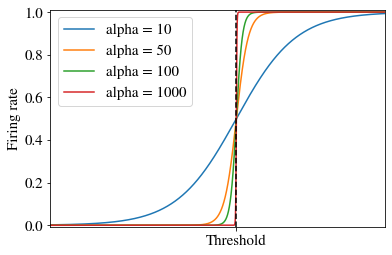

In [ ]:
F_max = 1
F_min = 0
threshold = 0.5

alpha = 10
plt.plot(np.arange(-10,1,0.0001), lambda_(np.arange(-10,1,0.0001), alpha), label = 'alpha = 10')

alpha = 50
plt.plot(np.arange(-10,1,0.0001), lambda_(np.arange(-10,1,0.0001), alpha), label = 'alpha = 50')

alpha = 100
plt.plot(np.arange(-10,1,0.0001), lambda_(np.arange(-10,1,0.0001), alpha), label = 'alpha = 100')

alpha = 1000
plt.plot(np.arange(-10,1,0.0001), lambda_(np.arange(-10,1,0.0001), alpha), label = 'alpha = 1000')



plt.xlim(-threshold/4,2*threshold,0.00000000000001)
plt.ylim(-0.01,1.01,0.000000001)
plt.axvline(threshold, ls='--', color = 'k')
plt.ylabel('Firing rate')
plt.xticks([threshold], ['Threshold'])
plt.legend()

# plt.savefig('alphas.png', format = 'png', dpi = 1200)
# files.download('alphas.png')
